## SPARC-4 mini-pipeline tools
***
# <font color='darkblue'>Bias and Flat-field calibrations</font> 

This notebook shows an example for combining a series of bias and flat exposures into the master calibration product of SPARC4 pipeline.

* Eder Martioli, LNA 20 Jun 2023

In [25]:
import os,sys
sys.path.append(os.path.dirname(os.getcwd()))
import sparc4_product_plots as s4plt
import sparc4_pipeline_lib as s4pipelib
import sparc4_db as s4db

## User inputs and database handling

In [26]:
# set night directory name
NIGHTDIR = '20230503'
# set raw data root directory
DATADIR =  "/Volumes/Samsung_T5/Data/SPARC4/minidata/"
# set reduced data root directory
REDUCEDDIR = "/Volumes/Samsung_T5/Data/SPARC4/minidata/reduced/"

# set SPARC4 channel
CHANNEL = 4  # 1, 2, 3 or 4

# whether or not to force reduction even if product already exists
FORCE = False

# get SPARC4 pipeline parameters
p = s4pipelib.init_s4_p(datadir=DATADIR,
                        reducedir=REDUCEDDIR,
                        nightdir=NIGHTDIR,
                        channels="{}".format(CHANNEL),
                        print_report=False)

# create database of raw data for reduction
db = s4db.create_db_from_observations(p['filelists'][CHANNEL-1], 
                                      p['DB_KEYS'], 
                                      include_img_statistics=p["INCLUDE_IMG_STATISTICS"], 
                                      include_only_fullframe=p["FULL_FRAMES_ONLY"], 
                                      output=p['s4db_files'][CHANNEL-1])

# detect all detector modes
detector_modes = s4db.get_detector_modes_observed(db, 
                                                  science_only=True,
                                                  detector_keys=p["DETECTOR_MODE_KEYWORDS"])
# get first valid key
mode_key = next(iter(detector_modes))

## Define input list and output product file names

In [27]:
# create a list of zeros for current detector mode
zero_list = s4db.get_file_list(db, 
                               obstype=p['BIAS_OBSTYPE_KEYVALUE'], 
                               detector_mode=detector_modes[mode_key])

# define file name of master bias 
master_zero = "{}/{}_s4c{}{}_MasterZero.fits".format(p['reduce_directories'][CHANNEL-1],
                                                     NIGHTDIR,
                                                     p['CHANNELS'][CHANNEL-1],
                                                     mode_key)

# create a list of flats for current detector mode
flat_list = s4db.get_file_list(db, 
                               obstype=p['FLAT_OBSTYPE_KEYVALUE'], 
                               detector_mode=detector_modes[mode_key])

# define file name of master flat
master_flat = "{}/{}_s4c{}{}_MasterDomeFlat.fits".format(p['reduce_directories'][CHANNEL-1],
                                                         NIGHTDIR,
                                                         p['CHANNELS'][CHANNEL-1],
                                                         mode_key)

# Run master calibration

In [28]:
# calculate master bias and save product to FITS
p = s4pipelib.run_master_calibration(p, 
                                     inputlist=zero_list, 
                                     output=master_zero, 
                                     obstype='bias', 
                                     data_dir=DATADIR, 
                                     reduce_dir=p['reduce_directories'][CHANNEL-1], 
                                     force=FORCE)

2023-06-20 17:31:22,102 astropop - INFO - reading file 0 from 5: /Volumes/Samsung_T5/Data/SPARC4/minidata//sparc4acs4/20230503/20230503_s4c4_004066_zero.fits  [file_collection]
/Users/eder/opt/anaconda3/lib/python3.9/site-packages/astropop/_db.py:93: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if k in self.keywords or add_columns:
/Users/eder/opt/anaconda3/lib/python3.9/site-packages/astropop/_db.py:52: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if item not in self.keywords:
/Users/eder/opt/anaconda3/lib/python3.9/site-packages/astropop/_db.py:33: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if name in self.keywords:
/Users/eder/opt/anaconda3/lib/python3.9/site-packages/astropop/_db.py:38: FutureWarning: elementwise comparison failed; ret

bias files: 5
gain: 0.8 electron / adu
processing frame 1 of 5
processing frame 2 of 5
processing frame 3 of 5
processing frame 4 of 5
processing frame 5 of 5


2023-06-20 17:31:25,104 astropop - INFO - Combining 5 images with median method.  [imcombine]


Normalization mean value: 400.72685546875005 electron


In [29]:
# calculate master dome flat and save product to FITS
p = s4pipelib.run_master_calibration(p, 
                                     inputlist=flat_list, 
                                     output=master_flat, 
                                     obstype='flat', 
                                     data_dir=DATADIR, 
                                     reduce_dir=p['reduce_directories'][CHANNEL-1], 
                                     normalize=True, 
                                     force=FORCE)

2023-06-20 17:31:25,401 astropop - INFO - reading file 0 from 5: /Volumes/Samsung_T5/Data/SPARC4/minidata//sparc4acs4/20230503/20230503_s4c4_001218_dflat.fits  [file_collection]
/Users/eder/opt/anaconda3/lib/python3.9/site-packages/astropop/_db.py:93: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if k in self.keywords or add_columns:
/Users/eder/opt/anaconda3/lib/python3.9/site-packages/astropop/_db.py:52: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if item not in self.keywords:
/Users/eder/opt/anaconda3/lib/python3.9/site-packages/astropop/_db.py:33: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if name in self.keywords:
/Users/eder/opt/anaconda3/lib/python3.9/site-packages/astropop/_db.py:38: FutureWarning: elementwise comparison failed; re

flat files: 5
gain: 0.8 electron / adu
processing frame 1 of 5
processing frame 2 of 5
processing frame 3 of 5
processing frame 4 of 5
processing frame 5 of 5


2023-06-20 17:31:29,911 astropop - INFO - Combining 5 images with median method.  [imcombine]


Normalization mean value: 28485.179230016467 electron


# Plot results

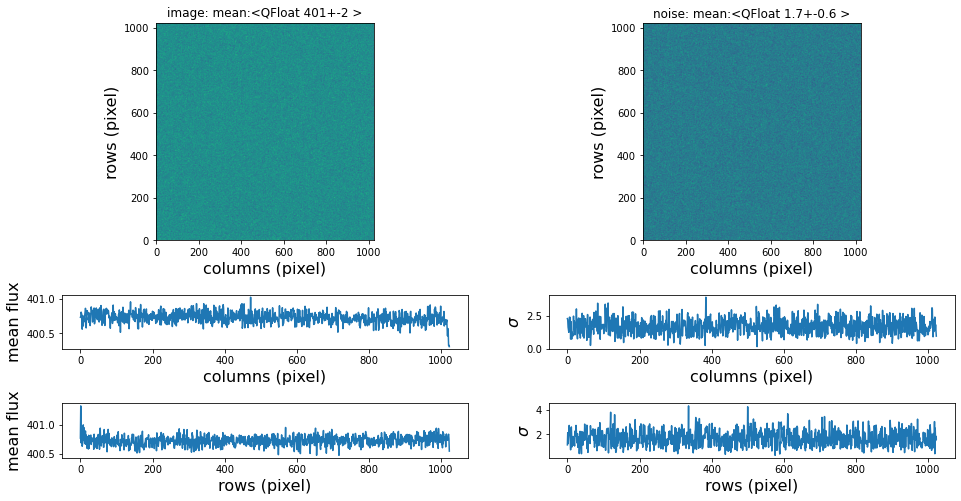

In [30]:
# plot master bias
s4plt.plot_cal_frame(master_zero, 
                     percentile=99.5, 
                     combine_rows=True, 
                     combine_cols=True)

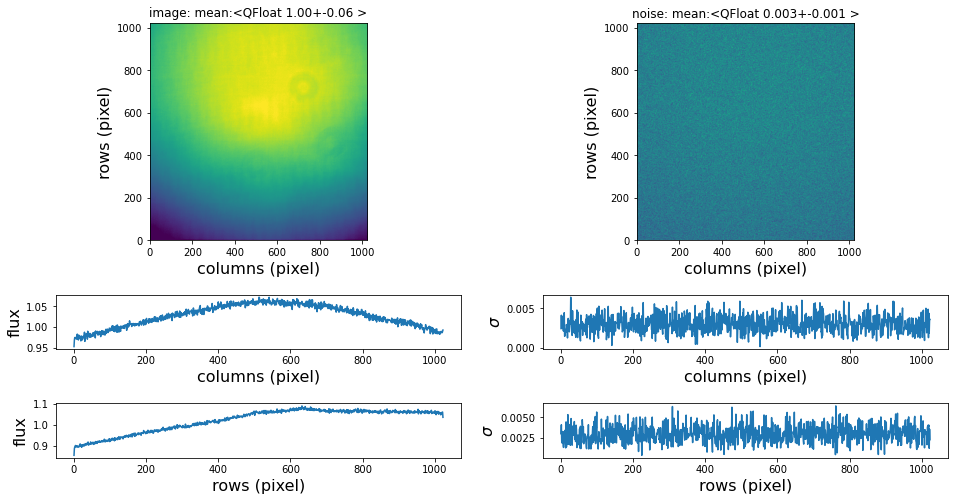

In [24]:
# plot master flat
s4plt.plot_cal_frame(master_flat, 
                     percentile=99.5, 
                     xcut=512, 
                     ycut=512)